## **ATOC4500 Data Science Lab: Final Project**
## **Using rapid ice loss events (RILE's) to predict when CESM1 and MPI-ESM2M ensemble members go ice free**
#### **Author: Daphne Quint, daqu2831@colorado.edu**
#### **Last updated: May 4th, 2022**

**This code is available on github:** https://github.com/doqhne/ATOC4500_sp22_final_project.git

---------------------------------------------------------------------------------------

### Introduction

The goal of this project is to determine if rapid ice loss events (RILE's) can be used to predict when a given ensemble member's sea ice extent will first go below 1 million square kilometers, i.e, when the ensemble member is considered "ice-free". In particular, I consider the longest rapid ice loss event and the event where the most ice is lost for each ensemble member. Currently, there is around 20 years of uncertainty for when a model will go ice free. Reducing this uncertainty could help scientists better understand the climate, and help us prepare for the future. I hypothesize that members with more ice lost and longer events will go ice free sooner than other members.

##### Data citation:

Deser, C., Lehner, F., Rodgers, K.B. et al. Insights from Earth system model
initial-condition large ensembles and future prospects. Nat. Clim. Chang. 10, 277–286
(2020). https://doi.org/10.1038/s41558-020-0731-2

### Import packages

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import datetime
import time
from google.colab import files

### Define functions

In [3]:
def find_year(data, member):
    '''
    Finds the year 1 member goes below 1 million square km
    '''
    
    data_ = data.sel(member=member)
    
    year = 2020
    for i in data_:
        if i>1:
            year += 1
        else:
            return year

In [1]:
def create_df(month, model_name, num_mems):
    '''
    Creates a dataframe with columns Member, month, ice free year, max ice lost, and max duration
    '''
    # select correct data
    if model_name == 'MPI_ESM1':
        nb_ext_data = nb_ext_data_MPI
        length_data = length_data_MPI
    else:
        nb_ext_data = nb_ext_data_CESM
        length_data = length_data_CESM
    
    #### find ice free year for that month
    
    ###first find 5 year mean
    
    # define September SIE
    SIE_sept = SIE[model_name].sel(time=SIE['time.month']==month).sel(member=np.arange(1, num_mems+1, 1))

    # find the 5 year running mean
    five_year_mean = SIE_sept*0

    for i in range(1, num_mems+1):
        five_year_mean[i-1] = SIE_sept.sel(member=i).rolling(time=5).mean()

    five_year_mean = five_year_mean.sel(time=slice('2020', '2100'))
    
    ### then find the ice free year
    ice_free_year = []
    for i in range(1, num_mems+1):
        ice_free_year.append(find_year(five_year_mean, i))
    ice_free_year = np.array(ice_free_year)
    
    #### find max amt of ice lost in the month
    
    ice_lost_max = []
    for i in range(1, num_mems+1):
        ice_lost_max.append(float(nb_ext_data['RILE Indicator'].sel(member=i).sel(month=month).min().values))
    ice_lost_max = np.array(ice_lost_max)
    
    #### find longest duration for the month
    
    length_max = []
    for i in range(1, num_mems+1):
        length_max.append(float(length_data['Length'].sel(member=i).sel(month=month).max().values))
    length_max = np.array(length_max)
    
    #### create dataframe
    
    member = pd.DataFrame(data=np.arange(1, num_mems+1), columns=['Member'])
    month = pd.DataFrame(data=(np.zeros(num_mems)+month), columns=['Month'])
    ice_free_yr_df = pd.DataFrame(data=ice_free_year, columns=['Ice Free Year'])
    ice_lost_max_df = pd.DataFrame(data=ice_lost_max, columns=['Max Ice Lost'])*-1
    length_max_df = pd.DataFrame(data=length_max, columns=['Longest Duration'])
    
    this_month_df = pd.concat([member, month, ice_free_yr_df, ice_lost_max_df, length_max_df], axis=1)
    
    return this_month_df

In [5]:
def define_holdout_data(x, y, verbose):
    """Perform a 80/20 test-train split (80% of data is training, 20% is testing). Split is randomized with each call."""
    random_state = randint(0,1000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)
    if verbose==True:
        print("Prior to scaling and rebalacing...")
        print("Shape of training predictors: "+str(np.shape(x_train)))
        print("Shape of testing predictors: "+str(np.shape(x_test)))
        print("Shape of training predictands: "+str(np.shape(y_train)))
        print("Shape of testing predictands: "+str(np.shape(y_test)))
        print(" ")
    return x_train, x_test, y_train, y_test

In [6]:
def scale_data(x_train, x_test):
    """
    Scale training data so that model reaches optimized weights much faster. 
    
    *All data that enters the model should use the same scaling used to scale the training data.*
    Thus, we also perform scaling on testing data for validation later. 
    Additionally, we return the scaler used to scale any other future input data.
    """
    
    scaler = preprocessing.MinMaxScaler() # normalize 
    x_train_scaled = pd.DataFrame(data=scaler.fit_transform(x_train),index=x_train.index,columns=x_train.columns) 
    x_test_scaled = pd.DataFrame(data=scaler.transform(x_test),index=x_test.index,columns=x_test.columns)
    
    return scaler, x_train_scaled, x_test_scaled

In [7]:
def balance_data(x,y,verbose):
    """Resample data ensure model is not biased towards a particular outcome of precip or no precip."""
    # Combine again to one dataframe to ensure both the predictor and predictand are resampled from the same 
    # observations based on predictand outcomes. 
    dataset = pd.concat([x, y],axis=1)

    # Separating classes
    early = dataset[dataset['early_bin'] == 1]
    not_early = dataset[dataset['early_bin'] == 0]

    random_state = randint(0,1000)
    oversample = resample(early, 
                           replace=True, 
                           n_samples=len(not_early), #set the number of samples to equal the number of the majority class
                           random_state=random_state)

    # Returning to new training set
    oversample_dataset = pd.concat([not_early, oversample])

    # reseparate oversampled data into X and y sets
    x_bal = oversample_dataset.drop(['early_bin'], axis=1)
    y_bal = oversample_dataset['early_bin']

    if verbose==True:
        print("After scaling and rebalacing...")
        print("Shape of predictors: "+str(np.shape(x_bal)))
        print("Shape of predictands: "+str(np.shape(y_bal)))
        print(" ")
    
    return x_bal, y_bal

In [8]:
def dataprep_pipeline(x, y, verbose):
    """ Combines all the functions defined above so that the user only has to 
    call one function to do all data pre-processing. """
    # verbose=True prints the shapes of input & output data

    # split into training & testing data
    x_train, x_test, y_train, y_test = define_holdout_data(x, y, verbose) 

    # perform feature scaling
    scaler, x_train_scaled, x_test_scaled = scale_data(x_train, x_test)

    # rebalance according to outcomes (i.e., the number of precipitating 
    # observations & non-precipitating outcomes should be equal)
    if verbose==True:
        print("for training data... ")
    x_train_bal, y_train_bal = balance_data(x_train_scaled, y_train, verbose)
    if verbose==True:
        print("for testing data... ")
    x_test_bal, y_test_bal = balance_data(x_test_scaled, y_test, verbose)
    
    return x_train_bal, y_train_bal, x_test_bal, y_test_bal

In [9]:
def bin_metrics(x, y):
    """Prints accuracy and recall metrics for evaluating 
    classification predictions."""
    
    accuracy = metrics.accuracy_score(x, y)
    recall = metrics.recall_score(x, y)

    print('Accuracy:', round(accuracy, 4))
    print('Recall:', round(recall, 4))
    
    return accuracy, recall

In [10]:
def plot_cm(x, y):
    """Plots the confusion matrix to visualize true 
    & false positives & negatives"""
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25}, fmt='g')# font size
    plt.ylim([0, 2])
    plt.xticks([0.5, 1.5], ['Negatives','Positives'])
    plt.yticks([0.5, 1.5], ['Negatives','Positives'])

In [11]:
def rand_atmos_conditions_precip(index='rand'):
    """
    Function returns atmospheric conditions in a dataframe as well as the scaled
    conditions in a numpy array so that they output a prediction in the model.
    
    If no input is passed, the function will randomly generate an in index to 
    choose from those observations in some training data with precipitation. 
    Otherwise, an integer index between 0 and 200 should be passed.
    """
    # First, perform a test-train split
    x_train, x_test, y_train, _ = define_holdout_data(x, y, verbose=False) 

    # perform feature scaling
    _, x_train_scaled, _ = scale_data(x_train, x_test)

    # this is what will go into the model to output a prediction
    if index=='rand':
        index = randint(0,len(y_train[y_train==1].index)) 
    precipindex = y_train[y_train==1].index.values[index]
    testpredictor = x_train_scaled.loc[precipindex] 
    
    return sept_df.iloc[precipindex], testpredictor 

## Step 1: Read in Data

#### Data description

I am using data from the Multi-Model Large Ensemble Archive. I am using sea ice extent data from the CESM1 model and the MPI-ESM2M model. I picked these models because the model sea ice extent is consistent with observations. This data covers the period from 1880-2100, with a time step of one month. The models both use a forcing of RCP8.5. There are no missing values. This dataset is widely used by climate system researchers, so I assume that the data is high quality. 

The other datasets loaded here are derived from the dataset described above. These are the datasets containing information about the length of RILE's, and the amount of sea ice lost for each member and month in the two models I consider.

In [ ]:
# upload RILE_nbext_CESM.nc, RILE_nbext_MPI.nc, CESM_rile_length.nc, MPI_rile_length.nc, and CLIVAR_SIE_1850_2100_RCP85.nc 
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving RILE_nbext_CESM.nc to RILE_nbext_CESM (2).nc
User uploaded file "RILE_nbext_CESM.nc" with length 1169496 bytes


Saving RILE_nbext_MPI.nc to RILE_nbext_MPI.nc
User uploaded file "RILE_nbext_MPI.nc" with length 2909496 bytes


Saving CESM_rile_length.nc to CESM_rile_length.nc
User uploaded file "CESM_rile_length.nc" with length 29251 bytes


Saving MPI_rile_length.nc to MPI_rile_length.nc
User uploaded file "MPI_rile_length.nc" with length 58531 bytes


Saving CLIVAR_SIE_1850_2100_RCP85.nc to CLIVAR_SIE_1850_2100_RCP85.nc
User uploaded file "CLIVAR_SIE_1850_2100_RCP85.nc" with length 14494350 bytes


In [12]:
# Amount of sea ice lost and Sea ice extent data for each RILE
nb_ext_data_CESM = xr.open_dataset('RILE_nbext_CESM.nc')
nb_ext_data_MPI = xr.open_dataset('RILE_nbext_MPI.nc')

# length data (consecutive years in a row there is a rile for that month)
length_data_CESM = xr.open_dataset('CESM_rile_length.nc')
length_data_MPI = xr.open_dataset('MPI_rile_length.nc')

# sea ice extent data - both models are included in this dataset
SIE = xr.open_dataset('CLIVAR_SIE_1850_2100_RCP85.nc')

FileNotFoundError: ignored

## Step 2: Munge Data

#### Description of data munging

Here I use the datasets loaded in the previous step to find the most extreme RILE and the longest RILE for each ensemble member. I also find the year each ensemble member goes ice-free, which occurs in September. 

I use a function I wrote called create_df that creates a pandas dataframe of these features given a month, model name, and number of ensemble members. The function can be found in the define functions section of the notebook. I create separate dataframes for CESM and MPI, and then concatenate them into one dataframe. Finally, I remove any rows that have any nan values to keep the data easy to work with. 

The final dataframe has 140 rows, with columns member, month, ice free year, max ice lost, and longest duration.

In [ ]:
# create dataframe for CESM
CESM_sept_df = create_df(9, 'CESM1', 40)

In [ ]:
# create dataframe for MPI
MPI_sept_df = create_df(9, 'MPI_ESM1', 100)

# add 40 to MPI members so they are distinct from CESM members
MPI_sept_df.Member = MPI_sept_df.Member + 40

In [ ]:
# concatenate the two dataframes to create a 'megamodel'
sept_df = pd.concat([CESM_sept_df, MPI_sept_df], ignore_index=True, sort=False)

In [ ]:
# check to see if there are nan values
print(np.any(np.isnan(sept_df)))

# drop nan values so they don't mess up the data science method
sept_df = sept_df.dropna()

True


In [ ]:
# look at the dataset
#sept_df

## Step 3: Apply Data Science Method

#### Description of data science method

I apply two different supervised machine learning methods to the dataset. First I try logistic regression, then I try random forest and compare their performance. Both of these methods use the test-train-split data science method. The data is split into two groups: one group is used to train the model, and the other is used to test how well the model works. 

The logistic regression works best for predicting a binary outcome, so instead of predicting a specific ice free year, I predict whether a member goes ice-free before a certain year. I use the same convention for the random forest analysis. One concern here for both machine learning methods is the relatively small sample size (140) I have. This makes it harder to get quality results. 

### Logistic Regression

In [ ]:
# select a year to separate the ice free column into 2 groups
ify_mean = sept_df['Ice Free Year'].mean()
ify_std  = sept_df['Ice Free Year'].std()
split_yr = ify_mean - (1.5*ify_std)
print(split_yr)

2045.970304392289


In [ ]:
# create a feature that indicates whether or not the member goes ice free before 2046
sept_df['early_bin'] = np.array(sept_df['Ice Free Year']<=2046).astype(int)

In [ ]:
# features that we will use to predict ice free year
x = sept_df.drop(['Month','Member', 'Ice Free Year', 'early_bin'],axis=1)

# what we are trying to predict- early ice free year
y = sept_df.drop(['Month','Member', 'Longest Duration', 'Max Ice Lost', 'Ice Free Year'], axis=1)

In [ ]:
# check to see if the results are balanced
y.value_counts()

early_bin
0            119
1             16
dtype: int64

In [ ]:
# Perform a test-train split, perform feature scaling, and the rebalance our dataset
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=True)

Prior to scaling and rebalacing...
Shape of training predictors: (108, 2)
Shape of testing predictors: (27, 2)
Shape of training predictands: (108, 1)
Shape of testing predictands: (27, 1)
 
for training data... 
After scaling and rebalacing...
Shape of predictors: (190, 2)
Shape of predictands: (190,)
 
for testing data... 
After scaling and rebalacing...
Shape of predictors: (48, 2)
Shape of predictands: (48,)
 


In [ ]:
# initialize the logistic regression model
lr = LogisticRegression(solver='lbfgs')

# fit the model to scaled & balanced training data
lr.fit(x_train_bal, y_train_bal);

Accuracy: 0.3958
Recall: 0.2083


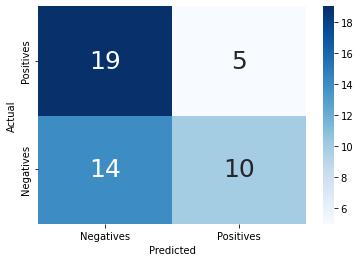

In [ ]:
# use the test data - data not used for the logistic regression - to see how well the model does
y_pred = lr.predict(x_test_bal)

# plot the confusion matrix
plot_cm(y_test_bal, y_pred);
lr_acc, lr_rec = bin_metrics(y_test_bal, y_pred)

In [ ]:
# check to see if the the logistic regression is overfitting or underfitting

# Compare testing data metrics to data training metrics
print("Training metrics:")
pred_train= lr.predict(x_train_bal) 
bin_metrics(y_train_bal,pred_train);

# As a reminder, display testing metrics
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, y_pred);

Training metrics:
Accuracy: 0.7105
Recall: 0.6421
 
Testing metrics:
Accuracy: 0.3958
Recall: 0.2083


Since testing metric is  less than the training metric, we may be overfitting, i.e, the model is too complex

In [ ]:
# Make a prediction with the Logistic Regression model
    # randomly choose some conditions using the rand_atmos_conditions function
origvals, testpredictor = rand_atmos_conditions_precip()

print(origvals) # observation from original dataframe
print("")
print(testpredictor) # scaled observation

Member                 2.000000
Month                  9.000000
Ice Free Year       2049.000000
Max Ice Lost           0.333348
Longest Duration       7.000000
early_bin              0.000000
Name: 1, dtype: float64

Max Ice Lost        0.171399
Longest Duration    0.187500
Name: 1, dtype: float64


In [ ]:
lr_prediction = lr.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance a member will go ice free in 2046 or before given those conditions.".format(lr_prediction, digits=2));

The conditions are: 
Member                 2.000000
Month                  9.000000
Ice Free Year       2049.000000
Max Ice Lost           0.333348
Longest Duration       7.000000
early_bin              0.000000
Name: 1, dtype: float64
 
There is a 39.47% chance a member will go ice free in 2046 or before given those conditions.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


### Random Forest

In [ ]:
# Perform a test-train split, perform feature scaling, and the rebalance our dataset
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False)

In [ ]:
# train and tune the random forest model

# choose the hyperparameters
    # choose to adjust the number of estimators in the forest and the depth of the tree
    
acc_scores = []
rec_scores = []

num_est = [10, 50, 500] # number of trees
depth = [2, 10, 100] # number of decisions
for i in num_est:
    start = time.time()
    print("Number of estimators is "+str(i))

    for k in depth:
        print("depth is "+str(k))
        forest = RandomForestClassifier(n_estimators=i, max_depth=k)
        forest.fit(x_train_bal, y_train_bal)
        
        # cross validate & evaluate metrics based on testing data
        pred_test= forest.predict(x_test_bal)
        acc_val = metrics.accuracy_score(y_test_bal, pred_test)
        acc_scores.append(acc_val)
        rec_val = metrics.recall_score(y_test_bal, pred_test)
        rec_scores.append(rec_val)

    end = time.time()
    print("Random Forest took "+str(end-start)+" seconds.")

Number of estimators is 10
depth is 2
depth is 10
depth is 100
Random Forest took 0.07848453521728516 seconds.
Number of estimators is 50
depth is 2
depth is 10
depth is 100
Random Forest took 0.26743340492248535 seconds.
Number of estimators is 500
depth is 2
depth is 10
depth is 100
Random Forest took 2.5309031009674072 seconds.


Max Accuracy (black): 0.9038
Max Recall (blue): 1.0


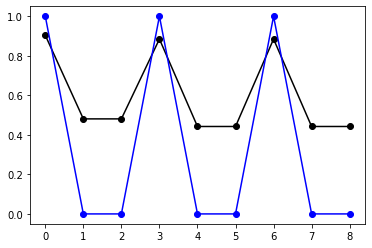

In [ ]:
plt.plot(acc_scores, marker='o', color='black')
plt.plot(rec_scores, marker='o', color='blue')
print("Max Accuracy (black):", round(max(acc_scores), 4))
print("Max Recall (blue):", round(max(rec_scores), 4))

In [ ]:
# hyper parameter selection - choose x=0 for maximum accuracy and recall
forest = RandomForestClassifier(n_estimators=10, max_depth=2);
forest.fit(x_train_bal, y_train_bal);

Accuracy: 0.8846
Recall: 1.0


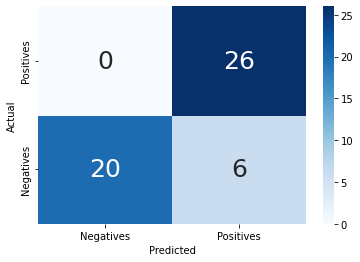

In [ ]:
# Assess the Random Forest's performance using testing data
pred_test= forest.predict(x_test_bal)

# Calculate metrics & plot a confusion matrix based on how well model simulates testing data
forest_acc, forest_rec = bin_metrics(y_test_bal, pred_test)

#plot
plot_cm(y_test_bal, pred_test)

In [ ]:
#Check to see if the Random Forest is overfitting

# Compare testing data metrics to data training metrics.
print("Training metrics:")
rf_pred_train= forest.predict(x_train_bal) 
bin_metrics(y_train_bal,rf_pred_train);

# display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.6989
Recall: 0.6129
 
Testing metrics:
Accuracy: 0.8846
Recall: 1.0


Since the training metrics are smaller than the testing metrics, we may be underfitting the model, i.e, the model should be more complex.

In [ ]:
# Make a prediction with the Random Forest

# prediction output is in the format [probability not before 2046, probability before 2046]
forest_prediction = forest.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance that a member will go ice free in 2046 or before given those conditions.".format(forest_prediction, digits=2))

The conditions are: 
Member                 2.000000
Month                  9.000000
Ice Free Year       2049.000000
Max Ice Lost           0.333348
Longest Duration       7.000000
early_bin              0.000000
Name: 1, dtype: float64
 
There is a 36.38% chance that a member will go ice free in 2046 or before given those conditions.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
model_metrics = pd.DataFrame({'Metrics':['Accuracy','Recall','Prediction example'],
     'Logistic Regression':[lr_acc, lr_rec, lr_prediction],
    'Random Forest':[forest_acc, forest_rec, forest_prediction]})
model_metrics = model_metrics.set_index('Metrics')
model_metrics

,Logistic Regression,Random Forest
Metrics,,
Accuracy,0.395833,0.884615
Recall,0.208333,1.000000
Prediction example,39.474894,36.384514


## Step 4: Present graphs visually using 2-3 graphs

### Confusion matrix for the logistic regression

The logistic regression performed poorly with an accuracy of 0.3958 and recall of 0.2083. In the matrix we can see that the model has 19 false negatives and 10 false positives. The model correctly identified only 5 true positives, which accounts for the low recall score.


<img src='https://drive.google.com/uc?id=1uM15S7c7JDMG4UvcDasRYp5mbT4SuYUt'>


 

### Confusion matrix for the random forest

The random forest performed very well in this dataset with an accuracy of 0.8846 and 1.0 recall, meaning that the model found all of the true positives. The random forest model had zero false negatives and 6 false positives. 


<img src='https://drive.google.com/uc?id=1K0VVOgwgdkljVCUS4DIjNMwMEZ5c0p0D'>

### Results - comparing logistic regression to random forest

Overall, the random forest has a significantly higher accuracy and recall than the logistic regression. 

<img src='https://drive.google.com/uc?id=1nX1zBnETNqYmOpbck2FH3mR9AhINO0ne'>

## Summary

In summary, the random forest appears to work well for this dataset. The random forest had an accuracy of 0.88, and perfect recall(1.0) when I ran the code. The logistic regression performed much worse when I ran the code, with an accuracy of 0.40 and a recall of 0.21. 

Both of these models could be improved. When running the logistic regression, I compared the training metrics (accuracy and recall) to the testing mettrics, and found that the testing metrics were greater than the training metrics, indicating that the model was overfitting the data. This makes sense because the sample size was low compared to number of parameters in the model. I had the opposite prolem with the random forest: the testing metrics were higher than the training metrics, which indicates that the model was underfitting the data.

Although these results seem promising, it is likely that the random selection of the testing and training data impacts how well the models do. When reviewers Laura and Ania ran my code, they found that the logistic regression outperformed the random forest - the opposite of my results. This is probably because the dataset I used is small (only 140 values), so a random splitting of the data may not have resulted in two similar datasets. Because of this, it is hard to say which method is better for this dataset because the test-train-split was done twice (once for each machine learning method). Because of this, it is still unclear how well RILE's can predict when an ensemble member goes ice-free. 